In [1]:
# Librerías
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
import pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
import statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.plot import set_dark_theme
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax

import warnings
warnings.filterwarnings('once')

c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sys
import os
current_dir = os.getcwd() # Obtener la ruta del directorio actual del notebook
ROOT_PATH = os.path.dirname(current_dir) # Obtener la ruta del directorio superior
sys.path.insert(1, ROOT_PATH) # Insertar la ruta en sys.path

import root 

In [3]:
ruta_df = root.DIR_DATA_STAGE + 'merged_df_consumption.csv'
datos = pd.read_csv(ruta_df)

In [4]:
len(datos)

15312

In [5]:
datos.head()

,datetime,date,target,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,...,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,lowest_price_per_mwh,highest_price_per_mwh,euros_per_mwh,eic_count,installed_capacity
0,2021-09-01 00:00:00,2021-09-01,5155.056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-01 01:00:00,2021-09-01,4953.258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-09-01 02:00:00,2021-09-01,4910.692,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-09-01 03:00:00,2021-09-01,4700.725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-01 04:00:00,2021-09-01,4857.681,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
datos['datetime'] = pd.to_datetime(datos['datetime'], format='%Y-%m-%d %H:%M:%S')
datos = datos.set_index('datetime')
datos = datos.asfreq('H')

C:\Users\jgome\AppData\Local\Temp\ipykernel_22960\774957575.py:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos = datos.asfreq('H')


In [7]:
datos.drop(columns=['date'],inplace=True)

In [8]:
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
print(f"El rango de fechas va desde {fecha_inicio} hasta {fecha_fin}")

El rango de fechas va desde 2021-09-01 00:00:00 hasta 2023-05-31 23:00:00


In [9]:
fin_train = '2022-12-31 23:59:59'

datos_train = datos.loc[:fin_train]
datos_test  = datos.loc[fin_train:]

c:\Users\jgome\anaconda3\envs\time_series\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


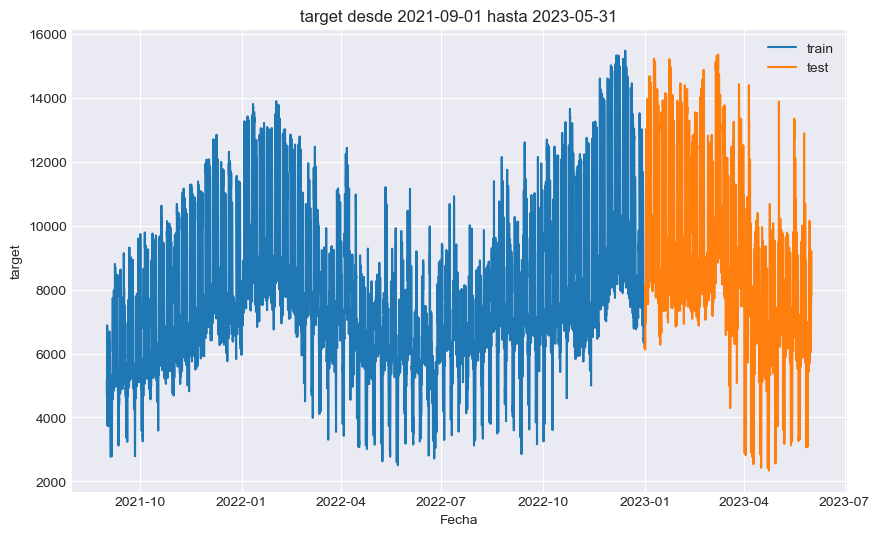

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(datos_train.index, datos_train['target'], label='train')
plt.plot(datos_test.index, datos_test['target'], label='test')
plt.xlabel("Fecha")
plt.ylabel('target')
plt.title(f"{'target'} desde {fecha_inicio.date()} hasta {fecha_fin.date()}")
plt.legend()
plt.show()

Test estacionariedad serie original
-------------------------------------
ADF Statistic: -9.960762216884586, p-value: 2.3770628713399818e-17
KPSS Statistic: 3.027630654608311, p-value: 0.01

Test estacionariedad para serie diferenciada (order=1)
--------------------------------------------------
ADF Statistic: -20.339987746477274, p-value: 0.0
KPSS Statistic: 0.0031248758442914914, p-value: 0.1

Test estacionariedad para serie diferenciada (order=2)
--------------------------------------------------
ADF Statistic: -33.92519499213692, p-value: 0.0
KPSS Statistic: 0.009951737243366178, p-value: 0.1


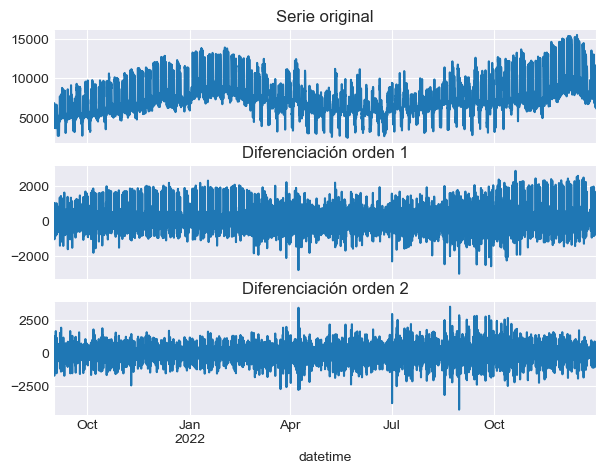

In [11]:
# Test estacionariedad
# ==============================================================================
warnings.filterwarnings("ignore")

datos_diff_1 = datos_train['target'].diff().dropna()
datos_diff_2 = datos_diff_1.diff().dropna()

print('Test estacionariedad serie original')
print('-------------------------------------')
adfuller_result = adfuller(datos['target'].dropna())
kpss_result = kpss(datos['target'].dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=1)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_1)
kpss_result = kpss(datos['target'].diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

print('\nTest estacionariedad para serie diferenciada (order=2)')
print('--------------------------------------------------')
adfuller_result = adfuller(datos_diff_2)
kpss_result = kpss(datos['target'].diff().diff().dropna())
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

warnings.filterwarnings("default")

# Gráfico series
# ==============================================================================
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(7, 5), sharex=True)
datos_train['target'].plot(ax=axs[0], title='Serie original')
datos_diff_1.plot(ax=axs[1], title='Diferenciación orden 1')
datos_diff_2.plot(ax=axs[2], title='Diferenciación orden 2');

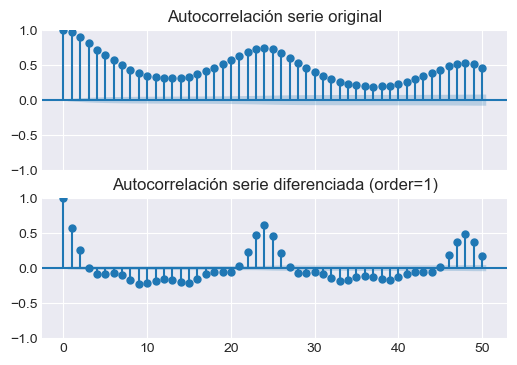

In [12]:
# Grafico de autocorrelación para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 4), sharex=True)
plot_acf(datos['target'].dropna(), ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación serie original')
plot_acf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('Autocorrelación serie diferenciada (order=1)');

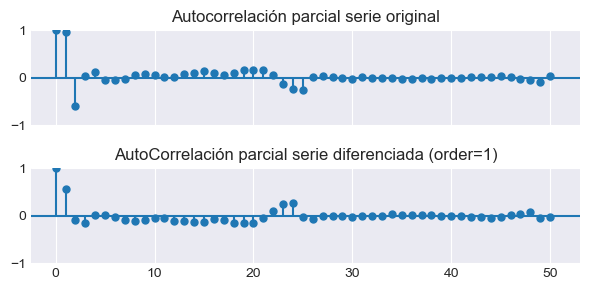

In [13]:
# Autocorrelación parcial para la serie original y la serie diferenciada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)
plot_pacf(datos['target'].dropna(), ax=axs[0], lags=50, alpha=0.05)
axs[0].set_title('Autocorrelación parcial serie original')
plot_pacf(datos_diff_1, ax=axs[1], lags=50, alpha=0.05)
axs[1].set_title('AutoCorrelación parcial serie diferenciada (order=1)');
plt.tight_layout(); 

In [46]:
# Descomposición de la serie original y la serie diferenciada
datos_target = pd.DataFrame(datos['target'])
#datos_target = datos_target.asfreq('h')
datos_target = datos_target.asfreq('H')
datos_target.head()

C:\Users\jgome\AppData\Local\Temp\ipykernel_22960\2893954270.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  datos_target = datos_target.asfreq('H')


,target
datetime,
2021-09-01 00:00:00,5155.056
2021-09-01 01:00:00,4953.258
2021-09-01 02:00:00,4910.692
2021-09-01 03:00:00,4700.725
2021-09-01 04:00:00,4857.681


In [47]:
print("Tipo de índice:", datos_target.index)

# Verificar si el índice tiene una frecuencia
print("Frecuencia del índice:", datos_target.index.freq)

Tipo de índice: DatetimeIndex(['2021-09-01 00:00:00', '2021-09-01 01:00:00',
               '2021-09-01 02:00:00', '2021-09-01 03:00:00',
               '2021-09-01 04:00:00', '2021-09-01 05:00:00',
               '2021-09-01 06:00:00', '2021-09-01 07:00:00',
               '2021-09-01 08:00:00', '2021-09-01 09:00:00',
               ...
               '2023-05-31 14:00:00', '2023-05-31 15:00:00',
               '2023-05-31 16:00:00', '2023-05-31 17:00:00',
               '2023-05-31 18:00:00', '2023-05-31 19:00:00',
               '2023-05-31 20:00:00', '2023-05-31 21:00:00',
               '2023-05-31 22:00:00', '2023-05-31 23:00:00'],
              dtype='datetime64[ns]', name='datetime', length=15312, freq='h')
Frecuencia del índice: <Hour>


In [48]:
datos_target.isnull().sum()

target    4
dtype: int64

In [49]:
datos_target_clean = datos_target.dropna()

In [50]:
type(datos_target_clean)

pandas.core.frame.DataFrame

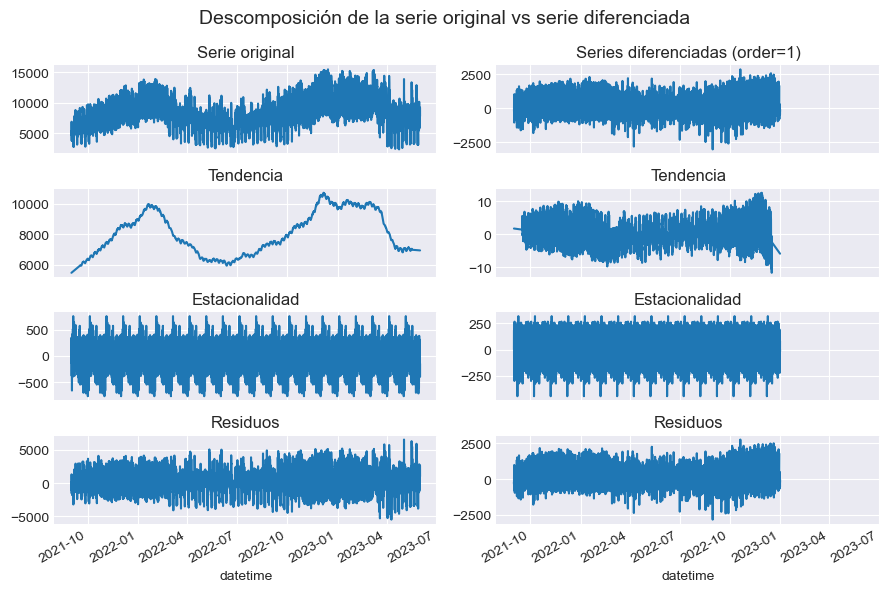

In [56]:
# ==============================================================================
res_decompose = seasonal_decompose(datos_target_clean, model='additive', extrapolate_trend='freq', period=730)
res_descompose_diff_2 = seasonal_decompose(datos_diff_1, model='additive', extrapolate_trend='freq', period=730)

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(9, 6), sharex=True)
res_decompose.observed.plot(ax=axs[0, 0])
axs[0, 0].set_title('Serie original', fontsize=12)
res_decompose.trend.plot(ax=axs[1, 0])
axs[1, 0].set_title('Tendencia', fontsize=12)
res_decompose.seasonal.plot(ax=axs[2, 0])
axs[2, 0].set_title('Estacionalidad', fontsize=12)
res_decompose.resid.plot(ax=axs[3, 0])
axs[3, 0].set_title('Residuos', fontsize=12)
res_descompose_diff_2.observed.plot(ax=axs[0, 1])
axs[0, 1].set_title('Series diferenciadas (order=1)', fontsize=12)
res_descompose_diff_2.trend.plot(ax=axs[1, 1])
axs[1, 1].set_title('Tendencia', fontsize=12)
res_descompose_diff_2.seasonal.plot(ax=axs[2, 1])
axs[2, 1].set_title('Estacionalidad', fontsize=12)
res_descompose_diff_2.resid.plot(ax=axs[3, 1])
axs[3, 1].set_title('Residuos', fontsize=12)
fig.suptitle('Descomposición de la serie original vs serie diferenciada', fontsize=14)
fig.tight_layout()

In [58]:
datos_diff_1_12 = datos_train['target'].diff().diff(12).dropna()

warnings.filterwarnings("ignore")
#adfuller_result = adfuller(datos_diff_1_12)
#print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')
kpss_result = kpss(datos_diff_1_12)
print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')
warnings.filterwarnings("default")

KPSS Statistic: 0.005558347772700401, p-value: 0.1
